## Introduction

An example of node classification on a homogeneous graph using the `Node2Vec` representation learning algorithm. The example uses components from the `stellargraph`, `Gensim`, and `scikit-learn` libraries.

**Note:** For clarity of exposition, this notebook forgoes the use of standard machine learning practices such as `Node2Vec` parameter tuning, node feature standarization, data splitting that handles class imbalance, classifier selection, and classifier tuning to maximize predictive accuracy. We leave such improvements to the reader.

### References

**1.** Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. ([link](https://snap.stanford.edu/node2vec/))

**2.** Distributed representations of words and phrases and their compositionality. T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean.  In Advances in Neural Information Processing Systems (NIPS), pp. 3111-3119, 2013. ([link](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf))

**3.** Gensim: Topic modelling for humans. ([link](https://radimrehurek.com/gensim/))

**4.** scikit-learn: Machine Learning in Python ([link](http://scikit-learn.org/stable/))

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd

import pymc3 as pm  # for probabilistic programming
import theano
import theano.tensor as tt

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

%matplotlib inline

/Users/eli024/anaconda3/envs/link-prediction/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Dataset


The dataset is the citation network Cora.

It can be downloaded by clicking [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz)

The following is the description of the dataset from the publisher,

> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details. 

For this demo, we ignore the word vectors associated with each paper. We are only interested in the network structure and the **subject** attribute of each paper.

Download and unzip the cora.tgz file to a location on your computer. 

We assume that the dataset is stored in the directory

`~/data/cora/`

where the files `cora.cites` and `cora.content` can be located.

We are going to load the data into a networkx object.

In [2]:
data_dir = "~/data/cora"

In [3]:
cora_location = os.path.expanduser(os.path.join(data_dir, "cora.cites"))
g_nx = nx.read_edgelist(path=cora_location)

# load the node attribute data
cora_data_location = os.path.expanduser(os.path.join(data_dir, "cora.content"))
node_attr = pd.read_csv(cora_data_location, sep='\t', header=None)
values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows()}
nx.set_node_attributes(g_nx, values, 'subject')

# Select the largest connected component. For clarity we ignore isolated
# nodes and subgraphs; having these in the data does not prevent the
# algorithm from running and producing valid results.
g_nx = max(nx.connected_component_subgraphs(g_nx, copy=True), key=len)
print("Largest subgraph statistics: {} nodes, {} edges".format(
    g_nx.number_of_nodes(), g_nx.number_of_edges()))

Largest subgraph statistics: 2485 nodes, 5069 edges


### The Node2Vec algorithm

The Node2Vec algorithm introduced in [1] is a 2-step representation learning algorithm. The two steps are,

1. Use 2nd order random walks to generate sentences from a graph. A sentence is a list of node ids. The set of all sentences makes a corpus.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node id is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The Word2Vec algorithm, [2], is used for calculating the embedding vectors.


## Corpus generation using random walks

The stellargraph library provides an implementation for 2nd order random walks as required by Node2Vec. The random walks have fixed maximum length and are controlled by two parameters `p` and `q`. See [1] for a detailed description of these parameters. 

We are going to start 10 random walks from each node in the graph with a length up to 100. We set parameter `p` to 0.5 and `q` to 2.0.

In [4]:
rw = BiasedRandomWalk(StellarGraph(g_nx))

walks = rw.run(nodes=list(g_nx.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=10,        # number of random walks per root node 
               p=0.5,       # Defines (unormalised) probability, 1/p, of returning to source node
               q=2.0        # Defines (unormalised) probability, 1/q, for moving away from source node
              )
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 24850


### Representation Learning using Word2Vec

We use the `Word2Vec`, [2], implementation in the free Python library `Gensim`, [3], to learn representations for each node in the graph.

We set the dimensionality of the learned embedding vectors to 128 as in [1].

In [5]:
from gensim.models import Word2Vec

model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [6]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
model.wv['19231'].shape

(128,)

### Visualise Node Embeddings

We retrieve the `Word2Vec` node embeddings that are 128-dimensional vectors and then we project them down to 2 dimensions using the [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm.

In [7]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ g_nx.node[node_id]['subject'] for node_id in node_ids]

In [8]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

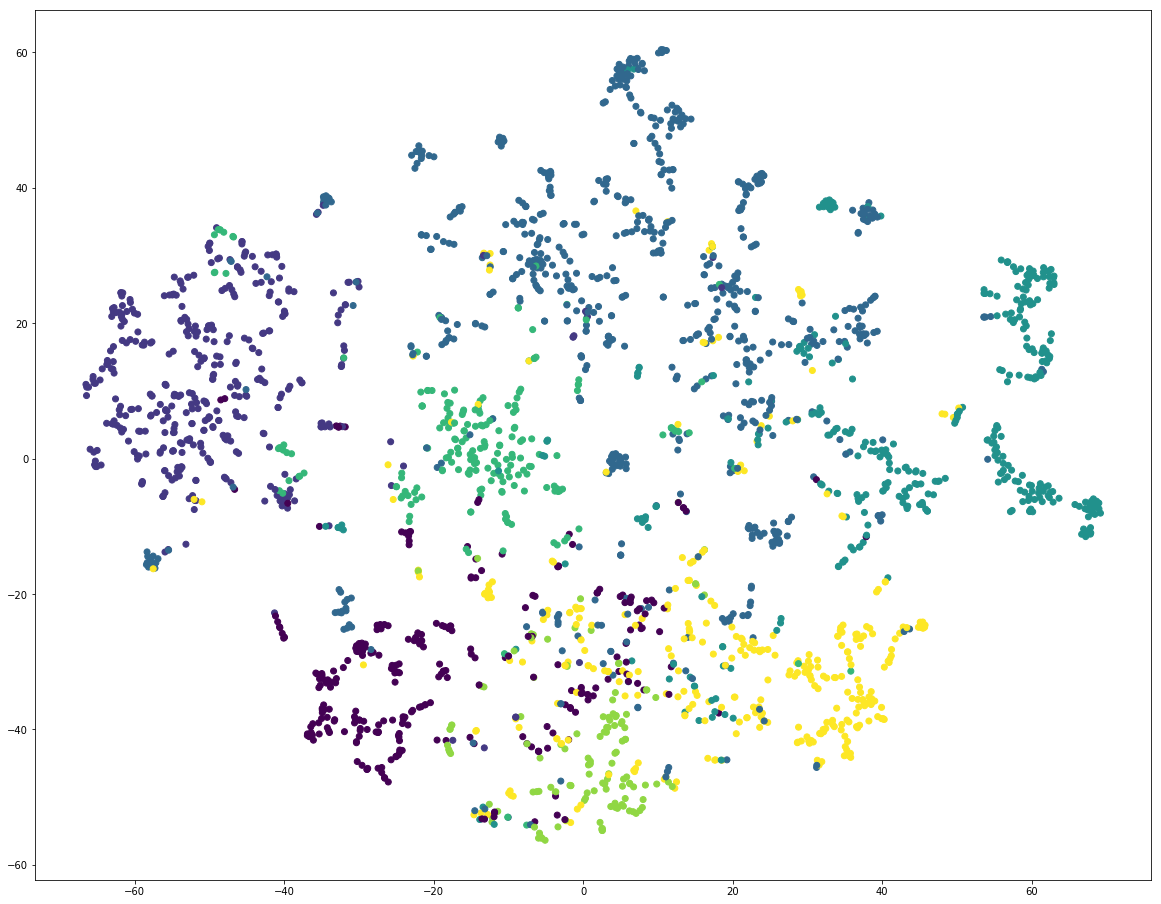

In [9]:
# draw the points
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,16))
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours)

### Downstream task

The node embeddings calculated using `Word2Vec` can be used as feature vectors in a downstream task such as node attribute inference. 

In this example, we will use the `Node2Vec` node embeddings to train a classifier to predict the subject of a paper in Cora.

In [10]:
# X will hold the 128-dimensional input features
X = node_embeddings  
# y holds the corresponding target values
y = np.array(node_targets)

We will reduce the dimensionality of the input data to 8 dimensions. 

We do this to make training the Bayesian model faster since we have to estimate the posterior distributions of fewer parameters.

In [104]:
n_components = 8
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(2485, 8)


### Data Splitting

We split the data into train and test sets. 

We use 75% of the data for training and the remaining 25% for testing as a hold out test set.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=0.75, test_size=None)

In [106]:
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Array shapes:
 X_train = (1863, 8)
 y_train = (1863,)
 X_test = (622, 8)
 y_test = (622,)


### Classifier Training

First, we train a standard Logistic Regression classifier on the training data. 

In [107]:
clf = LogisticRegressionCV( Cs=10, 
                            cv=10, 
                            scoring="accuracy",
                            verbose=False,
                            multi_class='ovr')
clf.fit(X_train, y_train)


LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='accuracy', solver='lbfgs', tol=0.0001,
           verbose=False)

Predict the hold out test set.

In [108]:
y_pred = clf.predict(X_test)

### Accuracy of standard Logistic Regression

Calculate the accuracy of the classifier on the test set.

In [109]:
accuracy_lr = accuracy_score(y_test, y_pred)
print("Logistic Regression accuracy: {}".format(accuracy_lr))

Logistic Regression accuracy: 0.7363344051446945


### Bayesian Classifier Training

Next, we train a Bayesian Logistic Regression classifier.

First we need to map the labels in 'y' to integers in the range 0...6 since there are 7 subjects in Cora

In [110]:
subjects = np.unique(y)
subject_mapper = { subject: i for i, subject in enumerate(subjects) }
subject_mapper

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [111]:
inv_subject_mapper = {v: k for k, v in subject_mapper.items()}

In [112]:
y_train_cat = np.array([ subject_mapper[subject] for subject in y_train])
y_test_cat = np.array([ subject_mapper[subject] for subject in y_test])
y_test_cat[:10]

array([0, 3, 6, 0, 6, 2, 6, 3, 4, 2])

Bayesian Logistic Regression model in PyMC3 from https://docs.pymc.io/notebooks/variational_api_quickstart.html

In [113]:
n_total = X_train.shape[0]  # number of data points
n_out = 7  # number of outcome categories
n_x = n_components  # number of predictors

### Bayesian model specification

In [114]:
# make these shared variables such that we can replace them with the test data later on.
Xt = theano.shared(X_train)
yt = theano.shared(y_train_cat)

with pm.Model() as blr_model:    
    # Creating the model
    beta = pm.Normal('beta', mu=0, sd=10, shape=(n_x, n_out))    
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=n_out)  # 7 subjects
    # alpha = pm.Flat('alpha', shape=(n_out,))
    #mu = tt.dot(Xt, beta) + alpha
    p = tt.nnet.softmax(Xt.dot(beta) + alpha)
    # p = pm.Deterministic('p', tt.nnet.softmax(mu))
    
    y_obs = pm.Categorical('y', p=p, observed=yt)

### Model training with MCMC

In [ ]:
with blr_model:
    step = pm.NUTS()  # Metropolis is much faster but it does not converge!
    #db = pm.backends.Text('test')  #.Text('test')
    trace = pm.sample(draws=2000, step=step, chains=2, cores=1)

    pm.traceplot(trace)

In [ ]:
#res = pm.plot_posterior(trace)

### Bayesian predictions

Now, we predict the test set, $X_{test}$. 

The **trace** variable holds the posterior samples for each parameter's marginal distribution.

In order to make a prediction (remember that we have one model for predicting each subject) we take one sample from the parameter posteriors for each model and then use it to predict the probability of that subject given the input features, $X_{test}$. We do this for all samples from the parameter posterior and all model in order to obtain a distribution of predictions.

In [ ]:
np.concatenate( (trace[0]['beta'][:, 0], [trace[0]['alfa'][0]]) )

In [115]:
def collect_posterior_samples(trace, model_index, beta='beta', alpha='alfa'):
    betas = np.array([ samples[beta][:, model_index] for samples in trace])
    alphas = np.array([ [samples[alpha][model_index]] for samples in trace])

    return betas, alphas

def predict(x, betas, alphas):
    y_pred = np.matmul(x, np.transpose(betas)).reshape(-1, 1) + np.array(alphas)
    # y_pred.shape
    y_pred = 1.0 / (1.0 + np.exp(-y_pred))
    #print(y_pred.shape)
    
    return y_pred

def predict_subject(x, trace, probs=False, beta='beta', alpha='alfa'):
    counts = np.zeros(7)
    for tr in trace:
        B = tr[beta]
        a = tr[alpha]
        preds = np.matmul(x, B) + a
        if probs:
            preds = 1.0 / (1.0 + np.exp(-preds))
        counts[np.argmax(preds)] += 1
    return counts

In [ ]:
model_index = 3
# Posterior samples of model parameters for predicting the 0th subject
model_betas, model_alphas = collect_posterior_samples(trace, model_index=model_index)

In [ ]:
print(len(model_betas))
print(len(model_alphas))

In [ ]:
X_test.shape

In [ ]:
print(model_betas.shape)
print(model_alphas.shape)

In [ ]:
model_betas = [ (collect_posterior_samples(trace, model_index=model_index))[0] for model_index in range(7)]
model_alphas = [ (collect_posterior_samples(trace, model_index=model_index))[1] for model_index in range(7)]

In [ ]:
y_pred = [ predict(x=X_test[0, :], betas=betas, alphas=alphas) for betas, alphas in zip(model_betas, model_alphas)]

In [ ]:
len(y_pred)

In [ ]:
f, ax = plt.subplots(len(y_pred), figsize=(12, 12), sharex=True, sharey=True)
#f.suptitle('probability')
for i in range(len(y_pred)):
    ax[i].hist(y_pred[i], bins=20)
    ax[i].set_title("Predictions for {} subject".format(inv_subject_mapper[i]))
    

In [ ]:
res = plt.hist(y_pred[0], bins=20)
plt.xlabel('probability')
plt.ylabel('count')
plt.title("Predictions for {} subject".format(inv_subject_mapper[model_index]))

In [ ]:
for i in range(len(y_pred)):
    sns.kdeplot(data=y_pred[i].reshape((-1,)), label=inv_subject_mapper[i])

### What is a better way to visualize the above predictions?

For each sample of model parameters, get the model that predicts the subject with the highest probability and record it. Then plot a histogram of the times each model won for this query? 

Is this useful way of visualising the Bayesian model's predictions?

In [ ]:
print(trace[0]['beta'].shape)
print(trace[0]['alfa'].shape)
print(X_test[0].shape)

In [ ]:
x = X_test[0].reshape(1,-1)
print(x.shape)
B = trace[0]['beta']
print(B.shape)

In [ ]:
y_pred = np.matmul(x, B) # + np.array(alphas)
print(y_pred.shape)
# y_pred.shape
y_pred = 1.0 / (1.0 + np.exp(-y_pred))
y_pred

In [ ]:
p = np.argmax(y_pred)
inv_subject_mapper[p]

In [ ]:
np.zeros(7).shape

In [ ]:
test_point_index = 20
counts = predict_subject(X_test[test_point_index], trace)
print(counts)
print("Subject predicted: {} vs true subject: {}".format(inv_subject_mapper[np.argmax(counts)], y_test[test_point_index]))

In [ ]:
plt.bar(range(len(counts)), height=counts)

Predict all the test points and compare accuracy with regards to ground truth.

In [ ]:
y_pred = []
for x in X_test:
    counts = predict_subject(x, trace)
    y_pred.append(inv_subject_mapper[np.argmax(counts)])
len(y_pred)

### Accuracy of Bayesian Logistic Regression

In [ ]:
accuracy_blr = accuracy_score(y_test, y_pred)
print("Bayesian Logistic Regression accuracy: {}".format(accuracy_blr))

### Compare the accuracies of the two models

In [ ]:
print("Logistic Regression accuracy is {:.3f} vs Bayesian Logistic Regression accuracy {:.3f}".format(accuracy_lr, accuracy_blr))

## Bayesian model training with VI

In [116]:
with blr_model:
    # We'll use SVGD
    inference = pm.SVGD(n_particles=500, jitter=1)

    # Local reference to approximation
    approx = inference.approx

    # Here we need `more_replacements` to change train_set to test_set
    test_probs = approx.sample_node(p, more_replacements={Xt: X_test}, size=100)

    # For train set no more replacements needed
    train_probs = approx.sample_node(p)

Let's setup monitoring of the train and test set accuracies during training. 

In [117]:
test_ok = tt.eq(test_probs.argmax(-1), y_test_cat)
train_ok = tt.eq(train_probs.argmax(-1), y_train_cat)
test_accuracy = test_ok.mean(-1)
train_accuracy = train_ok.mean(-1)

In [118]:
eval_tracker = pm.callbacks.Tracker(
    test_accuracy=test_accuracy.eval,
    train_accuracy=train_accuracy.eval
)

### Now do inference by calling fit()

In [119]:
 svgd_approx = inference.fit(100, obj_optimizer=pm.adamax(learning_rate=0.1), callbacks=[eval_tracker])

100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


#### Plot the train and test set accuracies for each training step.

/Users/eli024/anaconda3/envs/link-prediction/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0.5,1,'Training Progress')

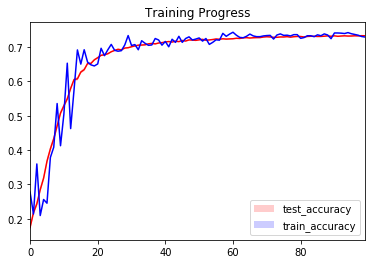

In [120]:
sns.tsplot(np.asarray(eval_tracker['test_accuracy']).T, color='red')
sns.tsplot(np.asarray(eval_tracker['train_accuracy']).T, color='blue')
plt.legend(['test_accuracy', 'train_accuracy'])
plt.title('Training Progress')

In [121]:
test_accuracy.eval()

array([0.73311897, 0.74115756, 0.73311897, 0.72990354, 0.73151125,
       0.72347267, 0.73151125, 0.73472669, 0.73633441, 0.73311897,
       0.72186495, 0.73954984, 0.72829582, 0.72186495, 0.72990354,
       0.74276527, 0.73954984, 0.72508039, 0.73472669, 0.73151125,
       0.73794212, 0.72990354, 0.73151125, 0.72990354, 0.73151125,
       0.74115756, 0.73472669, 0.72829582, 0.72990354, 0.74115756,
       0.72025723, 0.73794212, 0.73794212, 0.73633441, 0.73151125,
       0.72829582, 0.72508039, 0.73311897, 0.72347267, 0.73954984,
       0.72025723, 0.73794212, 0.73794212, 0.73311897, 0.72990354,
       0.73954984, 0.73472669, 0.73311897, 0.73472669, 0.7266881 ,
       0.72829582, 0.73311897, 0.73311897, 0.73954984, 0.72025723,
       0.73472669, 0.72829582, 0.72829582, 0.73954984, 0.73954984,
       0.73151125, 0.73151125, 0.72829582, 0.73954984, 0.74115756,
       0.73311897, 0.73472669, 0.73151125, 0.73151125, 0.73472669,
       0.73954984, 0.73151125, 0.73311897, 0.74437299, 0.72990

In [122]:
train_accuracy.eval()

array(0.74074074)

In [123]:
beta_samples = svgd_approx.sample_node(beta, size=200)
alpha_samples = svgd_approx.sample_node(alpha, size=200)
betas = beta_samples.eval()
alphas = alpha_samples.eval()

In [124]:
betas.shape

(200, 8, 7)

In [125]:
alphas.shape

(200, 7)

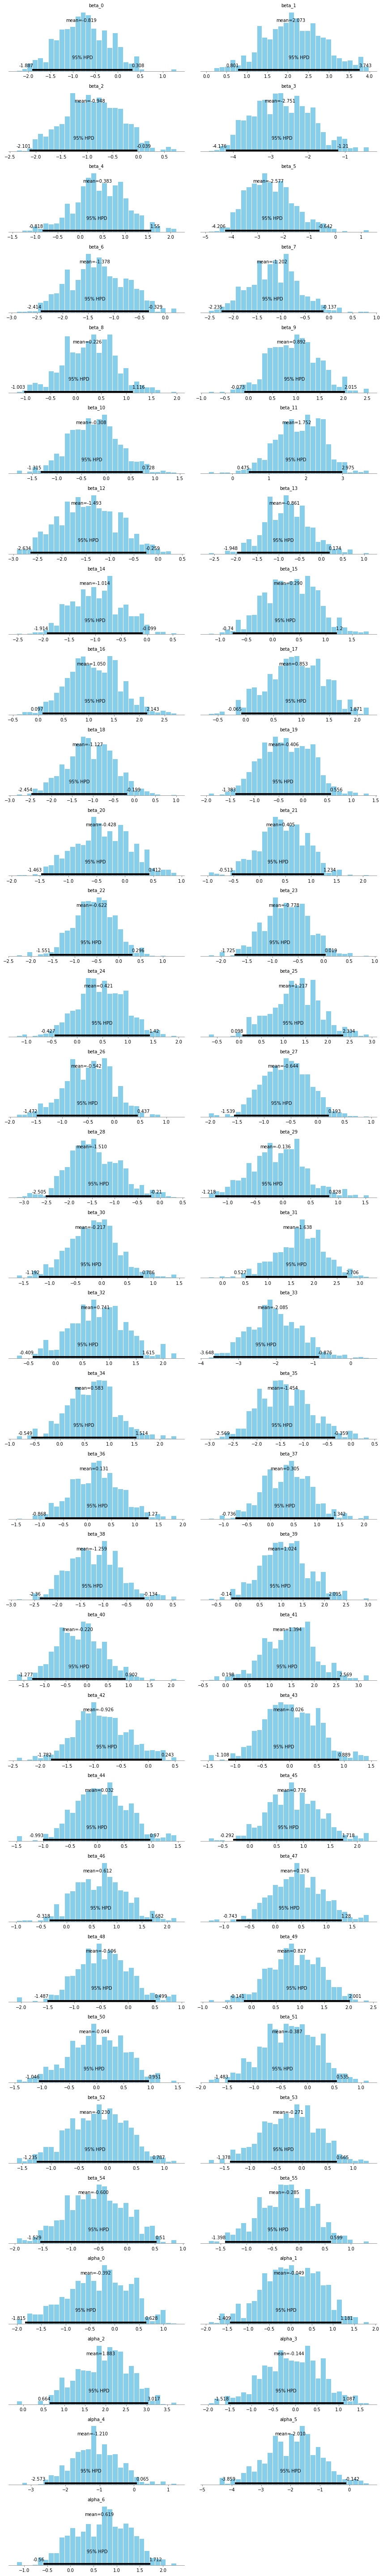

In [126]:
gr = pm.plot_posterior(svgd_approx.sample(2000))

In [127]:
ppc = pm.sample_approx(svgd_approx,draws=1000)

In [128]:
ppc

<MultiTrace: 1 chains, 1000 iterations, 2 variables>

In [152]:
def collect_posterior_samples(trace, model_index, beta='beta', alpha='alfa'):
    betas = np.array([ samples[beta][:, model_index] for samples in trace])
    alphas = np.array([ [samples[alpha][model_index]] for samples in trace])

    return betas, alphas

def predict(x, betas, alphas):
    """
    len(betas) and len(alphas) equals the number of samples from the posterior distributions
    of the parameters.
    
    betas[i] is the i-th n-dimensional sample of the linear coefficients.
    alphas[i] is the i-th 1-dimensional sample of the intercept
    """
    #y_pred = np.matmul(x, np.transpose(betas)).reshape(-1, 1) + np.array(alphas)
    y_pred = np.matmul(betas, x) + alphas
    print(y_pred.shape)
    #y_pred = 1.0 / (1.0 + np.exp(-y_pred))
    #print(y_pred.shape)
    y_pred = np.exp(y_pred)
    print(y_pred.shape)

    #total_preds = np.sum(y_pred)
    #print(total_preds)
    #y_pred = y_pred / total_preds

    return y_pred

def predict_subject(x, trace, probs=False, beta='beta', alpha='alfa'):
    counts = np.zeros(7)
    for tr in trace:
        B = tr[beta]
        a = tr[alpha]
        preds = np.matmul(x, B) + a
        if probs:
            preds = np.exp(preds)
            total_preds = np.sum(preds)
            #print(total_preds)
            preds = preds / total_preds
            #preds = 1.0 / (1.0 + np.exp(-preds))
        counts[np.argmax(preds)] += 1
    return counts

In [132]:
test_point_index = 0

In [133]:
pred_probs = predict_subject(X_test[test_point_index], trace=ppc, probs=True, beta='beta', alpha='alpha')
print(pred_probs)

[914.   0.  74.   0.   0.   0.  12.]


In [134]:
y_pred = []
for x in X_test:
    counts = predict_subject(x, trace=ppc, beta='beta', alpha='alpha')
    y_pred.append(inv_subject_mapper[np.argmax(counts)])
len(y_pred)

622

In [135]:
accuracy_blr_vi = accuracy_score(y_test, y_pred)
print("Bayesian Logistic Regression accuracy (VI): {}".format(accuracy_blr_vi))

Bayesian Logistic Regression accuracy (VI): 0.7347266881028939


In [136]:
counts = predict_subject(X_test[test_point_index], ppc, probs=True, alpha='alpha')
print(counts)
print("Subject predicted: {} vs true subject: {}".format(inv_subject_mapper[np.argmax(counts)], y_test[test_point_index]))

[914.   0.  74.   0.   0.   0.  12.]
Subject predicted: Case_Based vs true subject: Case_Based


## To Do

Label the x axis with the subject names.

<BarContainer object of 7 artists>

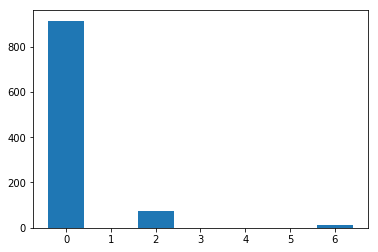

In [137]:
plt.bar(range(len(counts)), height=counts)

In [138]:
model_betas = [ (collect_posterior_samples(ppc, model_index=model_index, alpha='alpha'))[0] for model_index in range(7)]
model_alphas = [ (collect_posterior_samples(ppc, model_index=model_index, alpha='alpha'))[1] for model_index in range(7)]

In [139]:
[ (len(betas), len(betas[0]), len(alphas), len(alphas[0])) for betas, alphas in zip(model_betas, model_alphas)]

[(1000, 8, 1000, 1),
 (1000, 8, 1000, 1),
 (1000, 8, 1000, 1),
 (1000, 8, 1000, 1),
 (1000, 8, 1000, 1),
 (1000, 8, 1000, 1),
 (1000, 8, 1000, 1)]

In [145]:
X_test[test_point_index].reshape(-1,1).shape

(8, 1)

In [183]:
y_pred = [ predict(x=X_test[test_point_index, :].reshape(-1,1), betas=betas, alphas=alphas) for betas, alphas in zip(model_betas, model_alphas)]

x (8, 1)
betas (1000, 8)
alphas (1000, 1)
(1000, 1)
(1000, 1)
x (8, 1)
betas (1000, 8)
alphas (1000, 1)
(1000, 1)
(1000, 1)
x (8, 1)
betas (1000, 8)
alphas (1000, 1)
(1000, 1)
(1000, 1)
x (8, 1)
betas (1000, 8)
alphas (1000, 1)
(1000, 1)
(1000, 1)
x (8, 1)
betas (1000, 8)
alphas (1000, 1)
(1000, 1)
(1000, 1)
x (8, 1)
betas (1000, 8)
alphas (1000, 1)
(1000, 1)
(1000, 1)
x (8, 1)
betas (1000, 8)
alphas (1000, 1)
(1000, 1)
(1000, 1)


In [173]:
def predict(x, betas, alphas):
    """
    len(betas) and len(alphas) equals the number of samples from the posterior distributions
    of the parameters.
    
    betas[i] is the i-th n-dimensional sample of the linear coefficients.
    alphas[i] is the i-th 1-dimensional sample of the intercept
    """
    #y_pred = np.matmul(x, np.transpose(betas)).reshape(-1, 1) + np.array(alphas)
    print("x", x.shape)
    print("betas", betas.shape)
    print("alphas", alphas.shape)
    y_pred = np.matmul(betas, x) + alphas
    print(y_pred.shape)
    #y_pred = 1.0 / (1.0 + np.exp(-y_pred))
    #print(y_pred.shape)
    y_pred = np.exp(y_pred)
    print(y_pred.shape)

    #total_preds = np.sum(y_pred)
    #print(total_preds)
    #y_pred = y_pred / total_preds

    return y_pred


In [175]:
y_pred = predict(x=X_test[test_point_index, :].reshape(-1,1), betas=model_betas[0], alphas=model_alphas[0])

x (8, 1)
betas (1000, 8)
alphas (1000, 1)
(1000, 1)
(1000, 1)


In [186]:
len(y_pred) #.shape
len(y_pred[0]), y_pred[0][0]

(1000, array([4.82448474]))

In [197]:
y_pred = np.array(y_pred).reshape(7,-1)
y_pred.shape

(7, 1000)

In [200]:
totals = np.sum(y_pred, axis=0)
totals.shape

(1000,)

In [202]:
y_pred2 = y_pred/totals
y_pred2.shape

(7, 1000)

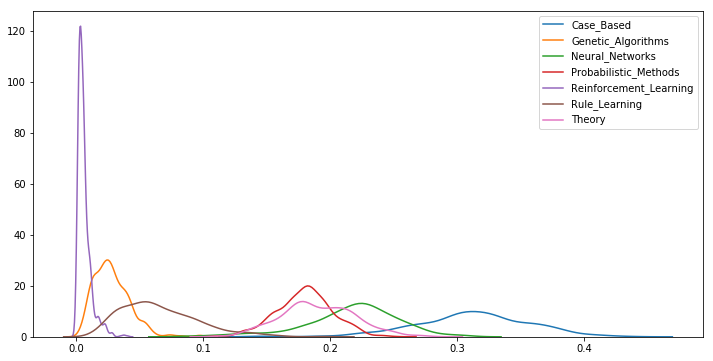

In [203]:
plt.figure(figsize=(12,6))
for i in range(len(y_pred)):
    sns.kdeplot(data=y_pred2[i].reshape((-1,)), label=inv_subject_mapper[i])
    #sns.kdeplot(data=y_pred[i], label=inv_subject_mapper[i])

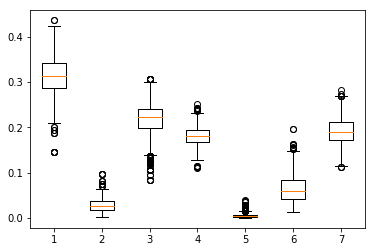

In [205]:
wh = plt.boxplot(x=y_pred2.T)

### Compare the accuracies of the two models

In [43]:
print("Logistic Regression accuracy is {:.3f} vs Bayesian Logistic Regression (VI) accuracy {:.3f}".format(accuracy_lr, accuracy_blr_vi))

Logistic Regression accuracy is 0.815 vs Bayesian Logistic Regression (VI) accuracy 0.818


## Logistic Regression vs Bayesian Logistic Regression

### Problem

We want to predict a binary outcome {0,1} given a single scalar predictor x.

We are given a set of N data points $D=\{y, x\}_0^{N-1}$ such that $y = \{ y_0, y_1, ..., y_{N-1} \}$ and $x = \{x_0, x_1, ..., x_{N-1}\}$ where $y$ are the target values and $x$ are the predictors (could be any d-dimensional vector). For simplicity, we assume that $x_i$ are scalar.

An example would be predicting whether a person is male given their height in cm. So, if we let male be represented by the value 1 and non-male by the value 0, then a datapoint would be $\{ y=1, x=182 \}$.

Logistic regresion learns to predict  $p(y=1|x, \alpha, \beta) = \sigma(\frac{1.}{1.0+e^{-(\alpha + \beta x})})$ where $\alpha, \beta$ are the intercept and slope respectively of a linear model. The linear term is know as the log odds, $log\frac{p(y=1|x)}{p(y=0|x)}=log\frac{p}{1-p}$, where $p$ is the probability of success, e.g., male in this example.

Fitting a logistic regression model is about estimating the values of the linear model parameters.

Binary logistic regression generalises to predicting more than one classes in which case we learn a model for each class with its own set of parameter values $\alpha_k, \beta_k$ for $k$ classes.

In multiclass logistic regression, the output probability for the k-th class is given by $p(y=k| x, \Theta^{0:k-1})=\frac{e^{\alpha_k+\beta_kx}}{\Sigma_{i=0}^{k-1}e^{\alpha_i+\beta_ix}}$ where $\Theta^{0:k-1} = \{\alpha, \beta \}^{0:k-1}$.

### Logistic Regression

Most commonly, when fitting a logistic regression model to data, we estimate a single value for each model parameter $\{\alpha, \beta\}$, that is the parameter values that maximise the likelihood of the data. 

This is commonly known as a point estimate. 

Given a new value $x$, we calculate the probability of a success outcome and apply a threshold to make a prediction.

### Bayesian Logistic Regression

In Bayesian logistic regression, when fitting the model, we estimate the posterior distributions of the parameters, $p(\alpha, \beta | D)$, conditioned on the observed data, $D$, our prior expectation of what is an appropriate range of parameter values, $p(\alpha, \beta)$ and the likelihood of the data, $p(D | \alpha, \beta)$.

The above quantities are all related via Bayes rule, $p(\Theta|D)=\frac{p(D|\Theta)p(\Theta)}{p(D)}$ where $\Theta = \{\alpha, \beta \}$.

The key idea is that instead of estimating a single value (a point estimate) for each of the parameters, $\alpha, \beta$, we estimate the joint distribution from which we can obtain the posterior distributions for each parameter via marginalisation, $p(\alpha | D)$ and $p(\beta | D)$.

Making a prediction given these posterior distributions produces a distribution of outcomes as opposed to a single estimate as with standard logistic regression.

We can make a prediction but sampling from the posterior distributions and for each sample calculate the probability of the outcome, e.g., whether a person is male or not given their height.

If we draw 1000 samples from the posterior then we get 1000 predictions that we can plot. Such a plot better shows our uncertainty on the predicted outcome.